# Wantedlab 사전과제 

> 작성자      
```
이정현 (junghyun30124@gmail.com)
```
[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

## 문제정의
* 주어진 문서를 직군에 따라 분류하는 모델학습.
* 모델의 성능을 검증하고 이를 통해 문서를 분류하는 모델을 서빙.

### 외부 모듈 설치
* #### 띄어쓰기 처리 라이브러리 설치
* #### 형태소 분석기 설치 (konlpy, customized konlpy)

In [ ]:
!apt install fonts-nanum*

In [ ]:
pip install ijson

In [ ]:
!pip install konlpy

In [ ]:
pip install customized_konlpy

### 모듈 및 라이브러리 불러오기

In [6]:
import os
import re
from collections import defaultdict, Iterable
import ijson
import pickle
import types
from pprint import pprint

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager
import seaborn as sns

from ckonlpy.tag import Twitter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
matplotlib.font_manager._rebuild()

In [ ]:
for i in font_manager.fontManager.ttflist:
    if 'Nanum' in i.name:
        print(i.name, i.fname)

In [9]:
file_path = '/content/drive/MyDrive/data'
file_name = 'jd_7632.json'

In [10]:
path = os.path.join(file_path, file_name)

## 탐색적 데이터 분석 (EDA)

```json
{'category': '개발',
  'main_tasks': '1. 운영중인 AWS기반의 ETL/ELT 개발 및 운영',
  'position': 'Data Engineer 담당 개발자',
  'preferred_points': '1. Crawling/Visualization에 특화된 솔루션 아키텍쳐 구성 경험\n'
                      '2. AWS 솔루션 환경에서의 개발 경험\n'
                      '3. MSA Telemetry Layer에 대한 기술적 이해\n'
                      '\n'
                      '\n'
                      '＜채용절차＞\n'
                      '- 서류접수\n'
                      '- 1차 대면 면접(담당 부서)\n'
                      '- 2차 대면 면접(임원)\n'
                      '- 최종합격',
  'requirements': '1. ES/Airflow/Kibana/Athena/QuickSight등의 서비스 기반 개발 경력\n'
                  '2. Query Language에 대한 기술적 이해와 활용능력 \n'
                  '3. Data Engineering 에 대한 기술적 이해와 경험',
  'wd_id': 51611}
```

## 데이터의 대표 통계량
1. 총 몇개의 데이터가 존재하는가?
2. class imbalance가 존재하는가?




In [11]:
f = open(path)
objects = ijson.items(f, '')                
for i, obj in enumerate(objects):
    if i == 0:
        pprint(len(obj))

7632


### Class imbalance Check

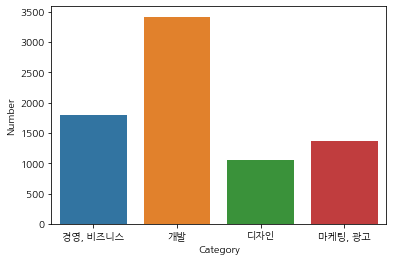

In [12]:
class2num = defaultdict(int)
f = open(path)
objects = ijson.items(f, '')
for o in next(objects):
    key = o['category']
    class2num[key] += 1

# pprint(isinstance(objects, collections.Iterable))                 # True
# pprint(isinstance(objects, types.Generator))                      # False

df = pd.DataFrame({
    'Category': class2num.keys(),
    'Number': class2num.values()
    })

plt.rc('font', family='NanumGothic')
sns.barplot(data=df, x='Category', y='Number')
plt.show()

### 키에 해당하는 분류 / 카테고리 성질

* main_tasks 와 preferred_points라는 키의 값들은 '\n'(개행)으로 각 항목이 나뉜다.
* ordered list이기도 하고 unordered list이기도 하다.

* **category**: 직군으로 분류되는 데이터, 라벨값이다.
    * 직군 클래스는 단 하나의 값을 가지는게 아니다. 
    * '경영, 비스니스'처럼 쉼표로 구분되어 들어갈 수 있다.
* **main_tasks**: 직무설명에 해당한다( 주요업무 ).
* **preferred_points**: 우대사항에 해당한다.
    * 개발의 경우 각각이 구체적으로 번호로 매겨져 있다.
    * 경험, 이해 라는 말이 주를 이룰것같다.
    * 채용절차 가 우대사항에 포함되어있다.
* **requirements**: 지원자격이다.
    * 번호로 구분된다.
    * 영문과 한글이 혼합되어 있다.
* **wd_id**: JD id (**w**ante**d_id**)
* **position**: 포지션 이름

* 이메일 기술
```json
{
    'wd_id': [JD ID],
    'position': [포지션 이름],
    'main_tasks': [주요 업무],
    'requirements': [자격 요건],
    'preferred_points': [우대사항],
    'category': [직군]
}
```


## 데이터 전처리 (Data Preprocessing)
* ordered list인 경우 숫자가 의미없으나, 항목묘사(1년 경력) 등에 의미가 부여되므로 삭제하지 않을 계획
* *, •, <, >, ■, ⦿ 과 같은 특수기호는 삭제
* 정규표현식으로 url의 형태는 삭제 (직접적인 연관 없음)
* '/'는 단어사이에 있을 때 유의미하게
* \n 행변환과같은 기호 또한 삭제
* ['경영, 비즈니스', '개발', '디자인', '마케팅, 광고'] 클래스 라벨링
    * [0, 1, 2, 3]



### 1. 번호 및 기호로 시작되는 리스트 제거 (Removing Ordered List)

*   number comes after "." will be replaced with "".
* in terms of 'preferred_points' (it could be None type)



In [13]:
def remove_bullets(texts):
    """
    input: list
    output: str
    """
    output = []
    for text in texts:
        text = re.sub(r'^\s*\d+\s*[-\\.)]?\s+|^\s*[-•■⦿*:º○▶️⏩✔]\s+', '', text).strip()
        output.append(text)
        
    return output

### 2. 불필요한 유니코드 및 특수문자 제거 (Removing Bad Characters)

* some bad unicode character : \u200b, \u202f, …, \ufeff


In [14]:
def remove_bad_char(texts):
    """
    문제를 일으킬 수 있는 문자들을 제거합니다.
    """
    output = []
    bad_chars = {"\u200b": "", "\u202f": "", "…": " ... ", "\ufeff": ""}
    for text in texts:
        for bad_char in bad_chars:
            text = text.replace(bad_char, bad_chars[bad_char])
        text = re.sub(r"[\+á?\xc3\xa1]", "", text)
        output.append(text)
    return output

* removing some unwanted characters

In [15]:
def remove_unwanted_symbol(texts):
    """
    &, ',', ':'를 제거합니다.
    """
    output = []
    for text in texts:
        text = text.replace('&', ' ').replace(',', '').replace(':', '')
        if text:
            output.append(text)
    return output

### URL형태의 주소 제거 (remove Url)

In [16]:
def remove_url(texts):
    """
    URL을 제거합니다.
    ``주소: www.naver.com`` -> ``주소: ``
    """
    preprocessed_text = []
    for text in texts:
        text = re.sub(r"(http|https)?:\/\/\S+\b|www\.(\w+\.)+\S*", "", text).strip()
        text = re.sub(r"pic\.(\w+\.)+\S*", "", text).strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

### 슬래쉬 기호 제거 (Removing forward slash)
* Foward slash usage between one letter (e.g. H/W)
    * remove foward slash
* Forward slash usage between two letters (e.g. Airflow/Mlflow)
    * replace forward slash with space(" ")

In [17]:
def replace_fslash(texts):
    """
    한글자씩 나뉜 글자는 붙여서 표시
    두글자로 나뉜 글자는 공백으로 구분
    """
    result = []
    fslash_pattern = re.compile("[\D]\/[\D]")
    for text in texts:
        target = fslash_pattern.match(text)
        if not target:
            text = text.replace("/", " ")
        else:
            text = text[:target.start()+1]+text[target.end()-1:]

        result.append(text)
    return result


### 불필요한 괄호 제거 (Remove useless brackets)
* [, <, ( and closing couterparts will be replaced with " "
* \1 in regular expression means 'backreference'

In [18]:
def remove_useless_bracket(texts):
    preprocessed_text = []
    # bracket_pattern = re.compile("[\<\(\[](.*?)[\]\)\>]", re.S)
    for text in texts:
        text = re.sub(r"[\<\(\[\]\)\>]", " ", text)
        if text:
            preprocessed_text.append(text)
 
    return preprocessed_text

### 두개이상의 연속된 공백을 제거 (remove repeated whitespace)

In [19]:
def remove_repeated_spacing(texts):
    """
    두 개 이상의 연속된 공백을 하나로 치환합니다.
    ``오늘은    날씨가   좋다.`` -> ``오늘은 날씨가 좋다.``
    """
    preprocessed_text = []
    for text in texts:
        text = re.sub(r"\s+", " ", text).strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

### 특정 불용어 제거 (remove particular stopwords)
* 직군 분류와 상관없는 단어들을 제거 (채용절차, 서류접수, 면접, 임원 등)

In [20]:
def filter_unwanted_word(texts):
    unwanted = ['채용절차', '서류접수', '면접', '임원', '최종합격']
    output = []
    for text in texts:
        text = re.sub(r"|".join(unwanted), "", text)
        if text:
            output.append(text)
    return output

* 문장이 ..분으로 끝날 때 '분'을 제거
    
    * e.g. 디자인 툴에 익숙하신 분 

In [21]:
def filter_ending(texts):
    context = []
    for text in texts:
        text = re.sub(r'분$', '', text)
        if text:
            context.append(text)
    return context

### 전처리 클래스 정의

In [52]:
import re

class Preprocessor:
    def __init__(self, document, kor_only=False, eng_only=False):
        """
        document: DataFrame
        kor_only: Boolean
        eng_only: Boolean
        """
        self.document = document
        self.cur_corpus = []
        self.pre_corpus = ""
        self.kor_only = kor_only
        self.eng_only = eng_only

    def remove_generals(self):
        skip = False
        stopwords = ['고용형태', '채용 프로세스', '채용 절차', '채용절차', '서류 접수', '직무 인터뷰', 'C-level 인터뷰',  '최종합격', '최종 합격', '서류접수', '면접',\
                     '개인정보 수집 및 이용동의서', '정규직',\
                     '국가유공자 예우 및 지원에 관한 법률에 의거 취업 보호 대상자 및 장애인은 관련 법규에 따라 우대합니다']
        for sent in self.document.split('\n'):
            for stop in stopwords:
                if stop in sent:
                    skip = True
                    break
            if not skip and sent:
                self.cur_corpus.append(sent)
            skip = False
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def remove_bullets(self):
        self.cur_corpus.clear()
        for sent in self.pre_corpus.split('\n'):
            sent = re.sub(r'^\s*\d+\s*[-\\.)]?\s+|^\s*[-•■⦿*:º○▶️⏩✔]\s+', '', sent).strip()
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def remove_bad_char(self):
        self.cur_corpus.clear()
        bad_chars = {"\u200b": "", "\u202f": "", "…": " ... ", "\ufeff": ""}
        for sent in self.pre_corpus.split('\n'):
            for bad_char in bad_chars:
                sent = sent.replace(bad_char, bad_chars[bad_char]).strip()
            sent = re.sub(r"[\+á?\xc3\xa1]", "", sent).strip()
            self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def remove_unwanted_symbol(self):
        self.cur_corpus.clear()
        for sent in self.pre_corpus.split("\n"):
            sent = re.sub(r'[-•■⦿*:º○▶️⏩✔&,:→＜＞]', ' ', sent).strip()
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def remove_url(self):
        self.cur_corpus.clear()
        for sent in self.pre_corpus.split("\n"):
            sent = re.sub(r"(http|https)?:\/\/\S+\b|www\.(\w+\.)+\S*", "", sent).strip()
            sent = re.sub(r"pic\.(\w+\.)+\S*", "", sent).strip()
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def replace_fslash(self):
        self.cur_corpus.clear()
        fslash_pattern = re.compile("[\D]\/[\D]")
        for sent in self.pre_corpus.split("\n"):
            target = fslash_pattern.match(sent)
            if not target:
                sent = sent.replace("/", " ").strip()
            else:
                sent = sent[:target.start()+1]+sent[target.end()-1:]
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def remove_bracket(self):
        self.cur_corpus.clear()
        for sent in self.pre_corpus.split("\n"):
            sent = re.sub(r"[\<\(\[\]\)\>]", " ", sent).strip()
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def remove_repeated_spacing(self):
        self.cur_corpus.clear()
        for sent in self.pre_corpus.split("\n"):
            sent = re.sub(r"\s+", " ", sent).strip()
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        self.pre_corpus = "\n".join(self.cur_corpus)

    def filter_ending(self):
        self.cur_corpus.clear()
        for sent in self.pre_corpus.split("\n"):
            sent = re.sub(r'분$', '', sent).strip()
            if sent:
                self.cur_corpus.append(sent)
        # save to the latest modified string with \n
        # self.pre_corpus = "\n".join(self.cur_corpus)
        self.pre_corpus = " ".join(self.cur_corpus)

    def preprocess_all(self):
        if self.document:
            self.remove_generals()
            self.remove_bullets()
            self.remove_bad_char()
            self.remove_unwanted_symbol()
            self.remove_url()
            self.replace_fslash()
            self.remove_bracket()
            self.remove_repeated_spacing()
            self.filter_ending()

    def get_prev_corpus(self):
        return self.pre_corpus

    def get_processed_corpus(self):
        return self.cur_corpus




* 첫 100개의 문서에 대한 전처리 결과 확인

In [23]:
f = open(path, encoding='utf-8')
objects = ijson.items(f, '')
iter_object = next(objects)
for i in range(1, len(iter_object)):
    for k, v in list(iter_object[i].items()):
        context = v
        if type(context) != int:
            if context == None:
                iter_object[i][k] = []
            else:
                p = Preprocessor(context) 
                p.preprocess_all()
                iter_object[i][k] = p.get_processed_corpus()
        else:
            iter_object[i][k] = [v]
        pprint("key:{} context:{}".format(k, iter_object[i][k]))
    if i == 50:
        break

'key:wd_id context:[61851]'
"key:position context:['집무실 IoT 개발자']"
("key:main_tasks context:['집무실 인프라 구축 IoT 전원 관리 설계 및 구성 QR 코드 기반 출입 제어 설계 및 구성 "
 "내부 네트워크 설계 구축 관리 IP Camera를 통한 영상 분석 등 집무실에서 사용하는 모든 네트워크 및 IoT 인프라 구축', "
 "'자동화 관리 구축된 인프라를 바탕으로한 집무실 공간 자동화 설계 및 구성', '현재 집무실에서는 이미 QR코드를 통해 출입을 제어하고 "
 "네트워크 및 전원 등을 리모트로 관리하고 있습니다. 이런 집무실의 인프라들을 구축하고 관리하게 됩니다.', '인프라중 직접 제어가 필요한 "
 "경우 개발을 진행합니다.', '위의 내용들을 바탕으로 공간 운영 자동화 무인화를 구축합니다.']")
("key:requirements context:['IoT를 통한 공간 관리 및 자동화에 대한 높은 관심이 있어야 합니다.', 'Linux "
 "시스템에 대한 이해가 필요합니다.', 'Python Javascript 등 코드를 작성하고 기본적인 하드웨어 제어를 할 수 있어야 "
 "합니다.', 'Git을 사용하고 이를 통한 협업을 충분히 이해해야 합니다.', '분산 원격 근무시 소통에 문제가 없어야 합니다.', "
 "'로켓펀치 개인 프로필을 충실히 기입한 후 지원하시기 바랍니다.']")
("key:preferred_points context:['적극적으로 서비스 개선에 필요한 업무를 찾고 개선할수 있는 인성과 역량', "
 "'Home Assistant SmartThings 등 IoT 허브 개발 경험', 'Raspberry PI Arduino ESP 등 "
 "Single Board Computer에 대한 이해 및 개발 경험', '공간 자동화 개발에 필요한 이해 및 구축 경험']")
"key:category context:['개발']"
'key:wd_id context:[618

### 각 문서의 항목별 컬럼을 구성한 데이터프레임을 작성

In [24]:
f = open(path, encoding='utf-8')
objects = ijson.items(f, '')
iter_object = next(objects)

df = pd.DataFrame(list(iter_object))

In [25]:
df.head()

,wd_id,position,main_tasks,requirements,preferred_points,category
0,61852,고객 경험(CX) 전략 매니저 (신입/인턴),• 24시간 365일 운영되는 로켓펀치와 집무실 고객 경험 관리\n• 고객 경험 사...,• 소셜 네트워크 또는 플랫폼 커뮤니티 등 온라인 플랫폼 운영에 관심이 있으신 분\...,• 회사와 함께 성장하고자 하는 의지를 가진 분\n• 다양한 이슈에 빠르게 대응하고...,"경영, 비즈니스"
1,61851,집무실 IoT 개발자,"• 집무실 인프라 구축: (IoT)전원 관리 설계 및 구성, QR 코드 기반 출입 ...",• IoT를 통한 공간 관리 및 자동화에 대한 높은 관심이 있어야 합니다.\n• ...,• 적극적으로 서비스 개선에 필요한 업무를 찾고 개선할수 있는 인성과 역량\n• ...,개발
2,61850,공간(인테리어) 디자이너,"- 공간 아이덴티티 : 숙박시설, 공용공간, 객실 등 공간의 아이덴티티를 기획하고 ...","• 여행, 숙박업, 접객업, 프랜차이즈업에 대한 경험과 이해\n• CAD, Sket...",• 숙박 운영 및 관리를 경험하신 분\n• 시니어 디자이너와 팀을 이뤄 프로젝트...,디자인
3,61849,Python 웹 어플리케이션 개발자,• 로켓펀치 웹 서비스 개발,• 웹 개발 업무 2년 이상이 있어야 합니다.\n• Python 및 Django/F...,• 적극적으로 서비스 개선에 필요한 업무를 찾고 개선할수 있는 인성과 역량\n• S...,개발
4,61848,여행 숙박 콘텐츠 마케터,• 투숙고객 대상 브랜딩-프로모션-예약-투숙-후기를 아우르는 일관된 마케팅 캠페인 ...,"• 2~5년간 미디어, PR, 광고, 콘텐츠 기획/제작을 경험하신 분\n• 복잡...","• 숙박운영, 스타트업 업무문화 경험자\n• 유튜브, 브런치 등 뉴미디어를 다양하...","마케팅, 광고"


In [33]:
len(df.index)

7632

### 각 문서의 항목별 내용을 하나의 문서로 나타냄
* 결측치를 빈 문자열로 대체하는 코드 포함

In [34]:
' '.join(dict(df.iloc[len(df.index)-1, 1:5]).values())

'Business Development Manager • Develop and execute a new business model\n• Accelerate B2B sales by F2F engagement, F2F-Mass sales, and/or Sell trough tactics; \n• Lead sales analytics required for sales targeting and be communication focal with marketing for marketing tactics development; \n• Assess the feasibility of projects/partnerships that will grow the GOGOX business. Lead the client pitches and proposals autonomously.\n• Monitor key metrics & competitive landscape, identify areas of improvement, and provide recommendations to improve the business\n• Drive multiple high impact cross-functional projects and oversee change management.\n• Identify revenue-generating features that aid in the development of strategic partnerships\n• Mentor and guide junior members of the team\n• Be a sounding board for the strategic initiatives and decisions of senior management staff\n• Handle ad hoc duties where necessary\n• • Proven Sales and/or Business Development experience in the logistics and

In [53]:
new_list = []
new_df = pd.DataFrame(columns=['doc', 'category'])
cols = ['position', 'main_tasks', 'requirements', 'preferred_points']

def func(doc):
    p = Preprocessor(doc) 
    p.preprocess_all()
    return p.get_prev_corpus()

# 결측치를 빈 문자열로 대체
df.fillna("", inplace=True)

for i in range(len(df.index)):
    text = ' '.join(dict(df.iloc[i, 1:5]).values())
    cate = df.iloc[i, -1]
    new_df.loc[i] = [text, cate]


new_df['doc'] = new_df['doc'].apply(lambda doc: func(doc))

In [54]:
new_df.head()

,doc,category
0,고객 경험 CX 전략 매니저 신입 인턴 24시간 365일 운영되는 로켓펀치와 집무실...,"경영, 비즈니스"
1,집무실 IoT 개발자 집무실 인프라 구축 IoT 전원 관리 설계 및 구성 QR 코드...,개발
2,공간 인테리어 디자이너 공간 아이덴티티 숙박시설 공용공간 객실 등 공간의 아이덴티티...,디자인
3,Python 웹 어플리케이션 개발자 로켓펀치 웹 서비스 개발 웹 개발 업무 2년 이...,개발
4,여행 숙박 콘텐츠 마케터 투숙고객 대상 브랜딩 프로모션 예약 투숙 후기를 아우르는 ...,"마케팅, 광고"


## 라벨을 범주형 변수로 변환하여 전처리

In [55]:
from sklearn import preprocessing

# Label encoding categorical value 
le = preprocessing.LabelEncoder()
target = new_df['category'].tolist()
le.fit(target)
repl = pd.Series(le.transform(target), name='category')
new_df['category'] = repl

### 훈련데이터와 검증데이터의 분리
* 전체 데이터셋중 훈련데이터는 80%, 검증데이터는 20%이다.

    * 각 데이터는 문서 카테고리의 분포 비율에 따라 나누어진다.

    stratify옵션에 label값을 제공

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(new_df.loc[:,'doc'], new_df.loc[:, 'category'], test_size=0.2, random_state=100, stratify=new_df['category'].tolist())

## Tf-Idf (Term Frequency - Inverse Document Frequency)

* 문서내 단어의 등장 빈도수에 따라 가중치를 내는 클래스를 정의하고 이를 통해 문서를 벡터화 하는 과정, 분류모델에 들어가는 수치화된 데이터이다.

> Unigram TF-IDF Vectorizer <br>
> Bigram TF-IDF Vectorizer <br>
> Trigram TF-IDF Vectorizer <br>

[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)에 제공할 tokenizer 함수 선언
* custom konlpy에서 제공하는 함수를 이용하여 형태소로 분석한다.
* tokenizer는 문자열 타입의 문서를 입력값으로 받고 리스트 타입으로 반환값을 반환해야 한다.

In [57]:
def mytokenizer(raw_sentence):
    twitter = Twitter()
    tagged_sentences = twitter.pos(raw_sentence)
    tokenized_sentence = []
    for word in tagged_sentences:
        if (word[1] not in ["Eomi", "Josa", "PreEomi"]):
            tokenized_sentence.append(word[0])           
    return tokenized_sentence

In [58]:
t_bow = TfidfVectorizer(tokenizer=mytokenizer, min_df=30, max_df=0.7, lowercase=False, stop_words={'engilsh'})
t_bow_bigram = TfidfVectorizer(tokenizer=mytokenizer, min_df=30, max_df=0.7, ngram_range=(1, 2), lowercase=False, stop_words={'engilsh'})
t_bow_trigram = TfidfVectorizer(tokenizer=mytokenizer, min_df=30, max_df=0.7, ngram_range=(1, 3), lowercase=False, stop_words={'engilsh'})

In [59]:
t_bow_feature = t_bow.fit_transform(new_df['doc'].values)
t_bow_bigram_feature = t_bow_bigram.fit_transform(new_df['doc'].values)
t_bow_trigram_feature = t_bow_trigram.fit_transform(new_df['doc'].values)

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [61]:
x_train_tfidf

<6105x2331 sparse matrix of type '<class 'numpy.float64'>'
	with 408262 stored elements in Compressed Sparse Row format>

In [62]:
x_train_tfidf = t_bow.transform(X_train)
x_train_bi_tfidf = t_bow_bigram.transform(X_train)
x_train_tri_tfidf = t_bow_trigram.transform(X_train)

x_test_tfidf = t_bow.transform(X_test)
x_test_bi_tfidf = t_bow_bigram.transform(X_test)
x_test_tri_tfidf = t_bow_trigram.transform(X_test)

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


벡터화 된 문서의 Shape을 확인

In [76]:
print(x_train_tfidf.shape)
print(x_train_bi_tfidf.shape)
print(x_train_tri_tfidf.shape)
print(x_test_tfidf.shape)
print(x_test_bi_tfidf.shape)
print(x_test_tri_tfidf.shape)

(6105, 2331)
(6105, 5350)
(6105, 6412)
(1527, 2331)
(1527, 5350)
(1527, 6412)


Corpus의 preferred_points에 해당하는 단어의 중요도에 따라 학습한 vectorizer를 pickle 파일로 저장하는 코드

In [64]:
pickle.dump(t_bow, open(os.path.join('/content/drive/MyDrive/data/models', 'doc_t_bow.pkl'), 'wb'))
pickle.dump(t_bow_bigram, open(os.path.join('/content/drive/MyDrive/data/models', 'doc_t_bow_bigram.pkl'), 'wb'))
pickle.dump(t_bow_trigram, open(os.path.join('/content/drive/MyDrive/data/models', 'doc_t_bow_trigram.pkl'), 'wb'))

## 모델 구성
* LightGBM
* Naive Bayes 
* Support Vector Machine

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state = 42)
lgbm_bi = LGBMClassifier(random_state = 42)
lgbm_tri = LGBMClassifier(random_state = 42)

lgbm.fit(x_train_tfidf,Y_train)
lgbm_bi.fit(x_train_bi_tfidf,Y_train)
lgbm_tri.fit(x_train_tri_tfidf,Y_train)

pred = lgbm.predict(x_test_tfidf)
pred_bi = lgbm_bi.predict(x_test_bi_tfidf)
pred_tri = lgbm_tri.predict(x_test_tri_tfidf)

In [66]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test,pred)
accuracy_bi = accuracy_score(Y_test,pred_bi)
accuracy_tri = accuracy_score(Y_test,pred_tri)

print("LightGBM uni-gram accuracy", accuracy)
print("LightGBM bi-gram accuracy", accuracy_bi)
print("LightGBM tri-gram accuracy", accuracy_tri)

LightGBM uni-gram accuracy 0.9325474787164375
LightGBM bi-gram accuracy 0.9305828421741977
LightGBM tri-gram accuracy 0.9325474787164375


In [68]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB().fit(x_train_tfidf, Y_train)
nb_bi = MultinomialNB().fit(x_train_bi_tfidf, Y_train)
nb_tri = MultinomialNB().fit(x_train_tri_tfidf, Y_train)

# predict the labels on validation dataset
nb_pred = nb.predict(x_test_tfidf)
nb_pred_bi = nb_bi.predict(x_test_bi_tfidf)
nb_pred_tri = nb_tri.predict(x_test_tri_tfidf)

print("Naive Bayes Accuracy Score (uni-gram) -> ",accuracy_score(nb_pred, Y_test)*100)
print("Naive Bayes Accuracy Score (bi-gram) -> ",accuracy_score(nb_pred_bi, Y_test)*100)
print("Naive Bayes Accuracy Score (tri-gram) -> ",accuracy_score(nb_pred_tri, Y_test)*100)

Naive Bayes Accuracy Score (uni-gram) ->  90.76620825147347
Naive Bayes Accuracy Score (bi-gram) ->  91.74852652259332
Naive Bayes Accuracy Score (tri-gram) ->  91.48657498362803


In [69]:
from sklearn.svm import SVC

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm_bi = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm_tri = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM training on each columns
svm.fit(x_train_tfidf, Y_train)
svm_bi.fit(x_train_bi_tfidf, Y_train)
svm_tri.fit(x_train_tri_tfidf, Y_train)
# predict the labels on validation dataset
svm_pred = svm.predict(x_test_tfidf)
svm_pred_bi = svm_bi.predict(x_test_bi_tfidf)
svm_pred_tri = svm_tri.predict(x_test_tri_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score (uni-gram) -> ",accuracy_score(svm_pred, Y_test)*100)
print("SVM Accuracy Score (bi-gram) -> ",accuracy_score(svm_pred_bi, Y_test)*100)
print("SVM Accuracy Score (tri-gram) -> ",accuracy_score(svm_pred_tri, Y_test)*100)

SVM Accuracy Score (uni-gram) ->  92.8618205631958
SVM Accuracy Score (bi-gram) ->  92.99279633267845
SVM Accuracy Score (tri-gram) ->  92.99279633267845


데이터를 학습한 모델을 pickle 파일로 저장하는 코드 

In [70]:
# saving each model
filenames = ['lgbm.pkl', 'lgbm_bi.pkl', 'lgbm_tri.pkl', 'nb.pkl', 'nb_bi.pkl', 'nb_tri.pkl', 'svm.pkl', 'svm_bi.pkl', 'svm_tri.pkl']
models = [lgbm, lgbm_bi, lgbm_tri, nb, nb_bi, nb_tri, svm, svm_bi, svm_tri]
if not os.path.isdir('/content/drive/MyDrive/data/models'):
    os.mkdir('/content/drive/MyDrive/data/models')

for i in range(len(filenames)):
    pickle.dump(models[i], open(os.path.join('/content/drive/MyDrive/data/models', filenames[i]), 'wb'))

## 임의의 문서에 대한 텍스트 분석

In [77]:
context = '• 광고대행사 아트디렉터 혹은 스타트업 광고/콘텐츠 디자이너 경력이 3년 이상이신 분을 찾습니다.\
• Adobe 소프트웨어 (photoshop, illustrator, after effects, premiere) 사용이 능숙하신 분을 찾습니다.\
• 브랜드 캠페인 경험이 있으신 분을 찾습니다\
• 자유 형식 포트폴리오 제출'
p = Preprocessor(context) 
p.preprocess_all()
context = p.get_processed_corpus()
print(context)
unseen_tfidf = t_bow.transform(context)
print(unseen_tfidf.shape)
lgbm_load = pickle.load(open('/content/drive/MyDrive/data/models/lgbm.pkl', 'rb'))
pred = lgbm_load.predict(unseen_tfidf)

['광고대행사 아트디렉터 혹은 스타트업 광고 콘텐츠 디자이너 경력이 3년 이상이신 분을 찾습니다. Adobe 소프트웨어 photoshop illustrator after effects premiere 사용이 능숙하신 분을 찾습니다. 브랜드 캠페인 경험이 있으신 분을 찾습니다 자유 형식 포트폴리오 제출']


/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


(1, 2331)


In [75]:
num2cat = {k: v for k, v in zip([0, 1, 2, 3], le.classes_)}
result = []
for i in pred:
    result.append(num2cat[i])
result

['디자인']